In [98]:
import pandas as pd
from gensim import downloader
import warnings
from tqdm.notebook import tqdm
import numpy as np
from nltk.tokenize import word_tokenize
import nltk
from skimpy import skim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    matthews_corrcoef,
    confusion_matrix,
)
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.naive_bayes import GaussianNB

nltk.download('punkt')
warnings.filterwarnings("ignore")
tqdm.pandas()

[nltk_data] Downloading package punkt to /Users/opop/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [44]:
df_train = pd.read_csv('../data/train_oversampled.csv')
df_val = pd.read_csv('../data/val_oversampled.csv')
df_test = pd.read_csv('../data/test.csv')

df_train.drop(columns=['Unnamed: 0'], inplace=True)
df_val.drop(columns=['Unnamed: 0'], inplace=True)

In [45]:
df_train.head()

,corrected_text,length,ratio_err,labels,is_generated
0,driverless cars aren really driverless and may...,595,0.006031,6,1
1,the author supports the idea that studying ven...,302,0.049669,1,0
2,have you ever studied about venus well its ver...,401,0.012469,3,0
3,driverless cars aren really driverless and may...,595,0.006031,6,1
4,the computer could help the classroom telling ...,219,0.018265,3,0


In [46]:
df_val.head()

,corrected_text,length,ratio_err,labels,is_generated
0,many people the united states are becoming mor...,427,0.011710,4,0
1,the article making mona lisa smile the author ...,211,0.022013,1,1
2,the electoral college was created with good in...,789,0.003802,6,0
3,say that the image the moon just natural land ...,512,0.044922,4,0
4,the author somewhat supports the idea venus wo...,399,0.000000,4,0


In [47]:
df_test.head()

,corrected_text,length,ratio_err,labels
0,venus future planet earth should take more ris...,284,0.003521,3
1,joining this program was the best there was fe...,359,0.022284,3
2,have you ever wonder you car was safe what you...,502,0.037849,1
3,the face mars very mysterious thing but only b...,484,0.010331,3
4,nearly everyone the united states has car they...,474,0.000000,4


<img src="./../../rsrc/exp.png" alt="Explanation Image" width="50" height="50">
<div style="border: 2px solid red; padding: 10px;">

* Since we are going to optimise the hyperparameters, we are going to use the Cross-Validation.

* That is why we have concatenated the test set and the validation set

</div>

In [48]:
df_train = pd.concat([df_train, df_val], ignore_index=True)

In [49]:
df_train.value_counts('labels')

labels
1    3084
2    3084
3    3084
4    3084
5    3084
6    3084
Name: count, dtype: int64

In [84]:
skim(df_train)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 18504  │ │ int64       │ 3     │                                                          │
│ │ Number of columns │ 5      │ │ string      │ 1     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name      ┃ NA   ┃ NA %   ┃ mean    ┃ sd      ┃ p0    ┃ p25     ┃ p50     ┃ p75   ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ length           │    0 │      0 │     430 │     170 │   150 │     270 │     460 │   600 │  1700 │   ▇▇▁   │  │
│ │ ratio_err        │    0 │      0 │   0.014 │   0.011 │     0 │   0.006 │   0.012 │  0.02 │  0.15 │   ▇▁    │  │
│ │ labels           │    0 │      0 │     3.5 │     1.7 │     1 │       2 │     3.5 │     5 │     6 │ ▇▇▇▇▇▇  │  │
│ │ is_generated     │    0 │      0 │     0.4 │    0.49 │     0 │       0 │       0 │     1 │     1 │ ▇    ▅  │  │
│ └──────────────────┴──────┴────────┴─────────┴─────────┴───────┴─────────┴─────────┴───────┴───────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                   ┃ NA     ┃ NA %       ┃ words per row               ┃ total words            ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ corrected_text                │      0 │          0 │                         360 │                6665292 │  │
│ └───────────────────────────────┴────────┴────────────┴─────────────────────────────┴────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

<img src="./../../rsrc/exp.png" alt="Explanation Image" width="50" height="50">
<div style="border: 2px solid red; padding: 10px;">

We need to get the embeddings of the texts

</div>

In [50]:
def word2vec(model, text: str) -> np.array:
    """
    Compute the word2vec with the GloVe model

    Args:
        model {model} -- the glove model
        text {str} -- the text
    Returns:
        np.array: the sentence embedding (mean of the word embeddings)
    """

    tokens = word_tokenize(text)
    cpt = 0
    word2vec = np.zeros(model.vector_size)
    for token in tokens:
        if token in model:
            cpt += 1
            word2vec += model[token]
    
    return word2vec / cpt

In [51]:
glove_model = downloader.load('glove-wiki-gigaword-300')

In [52]:
df_train['word2vec'] = df_train['corrected_text'].progress_apply(lambda x: word2vec(glove_model, x))
df_test['word2vec'] = df_test['corrected_text'].progress_apply(lambda x: word2vec(glove_model, x))

  0%|          | 0/18504 [00:00<?, ?it/s]

  0%|          | 0/3462 [00:00<?, ?it/s]

In [54]:
df_train.head()

,corrected_text,length,ratio_err,labels,is_generated,word2vec
0,driverless cars aren really driverless and may...,595,0.006031,6,1,"[-0.08177719598527441, 0.14934148915608986, -0..."
1,the author supports the idea that studying ven...,302,0.049669,1,0,"[-0.05220011447461068, 0.09064906918792985, -0..."
2,have you ever studied about venus well its ver...,401,0.012469,3,0,"[-0.09350407668299199, 0.11914931247412541, -0..."
3,driverless cars aren really driverless and may...,595,0.006031,6,1,"[-0.08123416266890297, 0.1497181596819452, -0...."
4,the computer could help the classroom telling ...,219,0.018265,3,0,"[-0.11268078570184566, 0.09609166186452768, -0..."


In [99]:
label_encoder = LabelEncoder()

df_train['labels'] = label_encoder.fit_transform(df_train['labels'])
df_test['labels'] = label_encoder.transform(df_test['labels'])

## Bayesian Models

<img src="./../../rsrc/exp.png" alt="Explanation Image" width="50" height="50">
<div style="border: 2px solid red; padding: 10px;">

No Hyperparameter needed

</div>

In [100]:
gaussian_nb = GaussianNB()
gaussian_nb.fit(np.stack(df_train['word2vec']), df_train['labels'])

GaussianNB()

In [101]:
print(classification_report(df_train['labels'], gaussian_nb.predict(np.stack(df_train['word2vec']))))
print("-" * 55)
print(classification_report(df_test['labels'], gaussian_nb.predict(np.stack(df_test['word2vec']))))

              precision    recall  f1-score   support

           0       0.81      0.70      0.75      3084
           1       0.39      0.58      0.47      3084
           2       0.36      0.15      0.21      3084
           3       0.40      0.51      0.45      3084
           4       0.79      0.78      0.79      3084
           5       1.00      0.96      0.98      3084

    accuracy                           0.62     18504
   macro avg       0.63      0.62      0.61     18504
weighted avg       0.63      0.62      0.61     18504

-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.11      0.09      0.10       251
           1       0.36      0.58      0.45       945
           2       0.45      0.14      0.22      1256
           3       0.35      0.52      0.42       785
           4       0.12      0.11      0.12       194
           5       0.00      0.00      0.00        31

    accuracy         

<img src="./../../rsrc/exp.png" alt="Explanation Image" width="50" height="50">
<div style="border: 2px solid red; padding: 10px;">

Scores aren't that good ! We will try to add more features to see how it will change


</div>

In [103]:
train_length = np.stack(df_train['word2vec'])
test_length = np.stack(df_test['word2vec'])

train_length = np.concatenate((train_length, np.array(df_train['length']).reshape(-1, 1)), axis=1)
test_length = np.concatenate((test_length, np.array(df_test['length']).reshape(-1, 1)), axis=1)

print(f"Shape of the train array: {train_length.shape}")
print(f"Shape of the test array: {test_length.shape}")

Shape of the train array: (18504, 301)
Shape of the test array: (3462, 301)


In [105]:
gnb_with_length = GaussianNB()
gnb_with_length.fit(train_length, df_train['labels'])

GaussianNB()

In [106]:
print(classification_report(df_train['labels'], gnb_with_length.predict(train_length)))
print("-" * 55)
print(classification_report(df_test['labels'], gnb_with_length.predict(test_length)))

              precision    recall  f1-score   support

           0       0.82      0.70      0.76      3084
           1       0.41      0.58      0.48      3084
           2       0.36      0.17      0.23      3084
           3       0.42      0.54      0.47      3084
           4       0.78      0.78      0.78      3084
           5       1.00      0.96      0.98      3084

    accuracy                           0.62     18504
   macro avg       0.63      0.62      0.62     18504
weighted avg       0.63      0.62      0.62     18504

-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.11      0.09      0.10       251
           1       0.38      0.58      0.46       945
           2       0.48      0.17      0.25      1256
           3       0.36      0.54      0.43       785
           4       0.11      0.12      0.12       194
           5       0.00      0.00      0.00        31

    accuracy         

In [107]:
print(f"Without length vs with length")
print(classification_report(df_test['labels'], gaussian_nb.predict(np.stack(df_test['word2vec']))))
print("-" * 55)
print(classification_report(df_test['labels'], gnb_with_length.predict(test_length)))

Without length vs with length
              precision    recall  f1-score   support

           0       0.11      0.09      0.10       251
           1       0.36      0.58      0.45       945
           2       0.45      0.14      0.22      1256
           3       0.35      0.52      0.42       785
           4       0.12      0.11      0.12       194
           5       0.00      0.00      0.00        31

    accuracy                           0.34      3462
   macro avg       0.23      0.24      0.22      3462
weighted avg       0.35      0.34      0.31      3462

-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.11      0.09      0.10       251
           1       0.38      0.58      0.46       945
           2       0.48      0.17      0.25      1256
           3       0.36      0.54      0.43       785
           4       0.11      0.12      0.12       194
           5       0.00      0.00      0.00   

<img src="./../../rsrc/exp.png" alt="Explanation Image" width="50" height="50">
<div style="border: 2px solid red; padding: 10px;">

* What about the ratio_err feature ?

</div>

In [108]:
train_ratio_err = np.stack(df_train['word2vec'])
test_ratio_err = np.stack(df_test['word2vec'])

train_ratio_err = np.concatenate((train_ratio_err, np.array(df_train['ratio_err']).reshape(-1, 1)), axis=1)
test_ratio_err = np.concatenate((test_ratio_err, np.array(df_test['ratio_err']).reshape(-1, 1)), axis=1)

print(f"Shape of the train array: {train_ratio_err.shape}")
print(f"Shape of the test array: {test_ratio_err.shape}")

Shape of the train array: (18504, 301)
Shape of the test array: (3462, 301)


In [109]:
gnb_with_ratio_err = GaussianNB()
gnb_with_ratio_err.fit(train_ratio_err, df_train['labels'])

print(classification_report(df_train['labels'], gnb_with_ratio_err.predict(train_ratio_err)))
print("-" * 55)
print(classification_report(df_test['labels'], gnb_with_ratio_err.predict(test_ratio_err)))

              precision    recall  f1-score   support

           0       0.81      0.70      0.75      3084
           1       0.39      0.59      0.47      3084
           2       0.36      0.15      0.22      3084
           3       0.41      0.51      0.45      3084
           4       0.80      0.78      0.79      3084
           5       1.00      0.96      0.98      3084

    accuracy                           0.62     18504
   macro avg       0.63      0.62      0.61     18504
weighted avg       0.63      0.62      0.61     18504

-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.11      0.09      0.10       251
           1       0.37      0.59      0.45       945
           2       0.47      0.15      0.23      1256
           3       0.35      0.51      0.41       785
           4       0.12      0.11      0.11       194
           5       0.00      0.00      0.00        31

    accuracy         

In [110]:
print(f"Without ratio_err vs with ratio_err")
print(classification_report(df_test['labels'], gnb_with_length.predict(test_length)))
print("-" * 55)
print(classification_report(df_test['labels'], gnb_with_ratio_err.predict(test_ratio_err)))

Without ratio_err vs with ratio_err
              precision    recall  f1-score   support

           0       0.11      0.09      0.10       251
           1       0.38      0.58      0.46       945
           2       0.48      0.17      0.25      1256
           3       0.36      0.54      0.43       785
           4       0.11      0.12      0.12       194
           5       0.00      0.00      0.00        31

    accuracy                           0.36      3462
   macro avg       0.24      0.25      0.23      3462
weighted avg       0.38      0.36      0.33      3462

-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.11      0.09      0.10       251
           1       0.37      0.59      0.45       945
           2       0.47      0.15      0.23      1256
           3       0.35      0.51      0.41       785
           4       0.12      0.11      0.11       194
           5       0.00      0.00      0

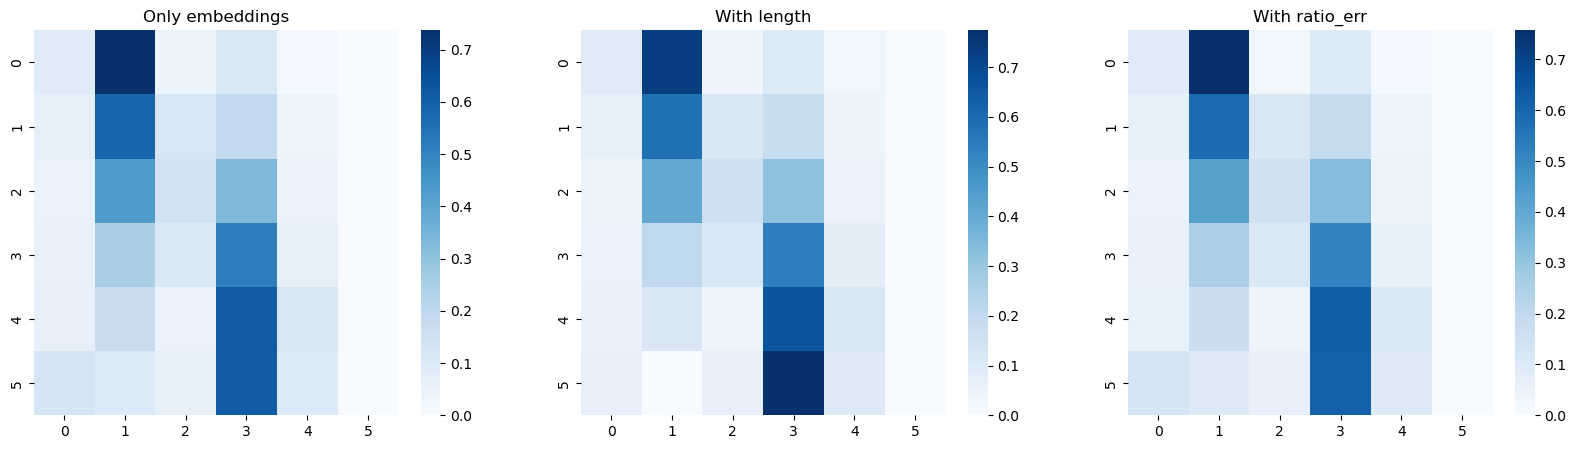

In [111]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

conf_matrix = confusion_matrix(df_test['labels'], gaussian_nb.predict(np.stack(df_test['word2vec'])))
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=False, ax=ax[0], fmt=".2f", cmap="Blues")
ax[0].set_title("Only embeddings")

conf_matrix = confusion_matrix(df_test['labels'], gnb_with_length.predict(test_length))
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=False, ax=ax[1], fmt=".2f", cmap="Blues")
ax[1].set_title("With length")

conf_matrix = confusion_matrix(df_test['labels'], gnb_with_ratio_err.predict(test_ratio_err))
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=False, ax=ax[2], fmt=".2f", cmap="Blues")
ax[2].set_title("With ratio_err")

plt.show()

<img src="./../../rsrc/exp.png" alt="Explanation Image" width="50" height="50">
<div style="border: 2px solid red; padding: 10px;">

* Oversampling, why ?

</div>

In [112]:
df_train_non_generated = df_train[df_train['is_generated'] == 0]

In [113]:
gnb_unbalanced = GaussianNB()
gnb_unbalanced.fit(np.stack(df_train_non_generated['word2vec']), df_train_non_generated['labels'])

GaussianNB()

In [114]:
print(classification_report(df_train_non_generated['labels'], gnb_unbalanced.predict(np.stack(df_train_non_generated['word2vec']))))
print("-" * 55)
print(classification_report(df_test['labels'], gnb_unbalanced.predict(np.stack(df_test['word2vec']))))

              precision    recall  f1-score   support

           0       0.22      0.53      0.31      1001
           1       0.45      0.33      0.38      3084
           2       0.34      0.13      0.19      3084
           3       0.40      0.33      0.36      3084
           4       0.15      0.20      0.17       776
           5       0.06      0.81      0.11       125

    accuracy                           0.29     11154
   macro avg       0.27      0.39      0.25     11154
weighted avg       0.36      0.29      0.30     11154

-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.19      0.55      0.28       251
           1       0.42      0.34      0.38       945
           2       0.47      0.14      0.22      1256
           3       0.33      0.32      0.32       785
           4       0.11      0.17      0.13       194
           5       0.04      0.68      0.08        31

    accuracy         

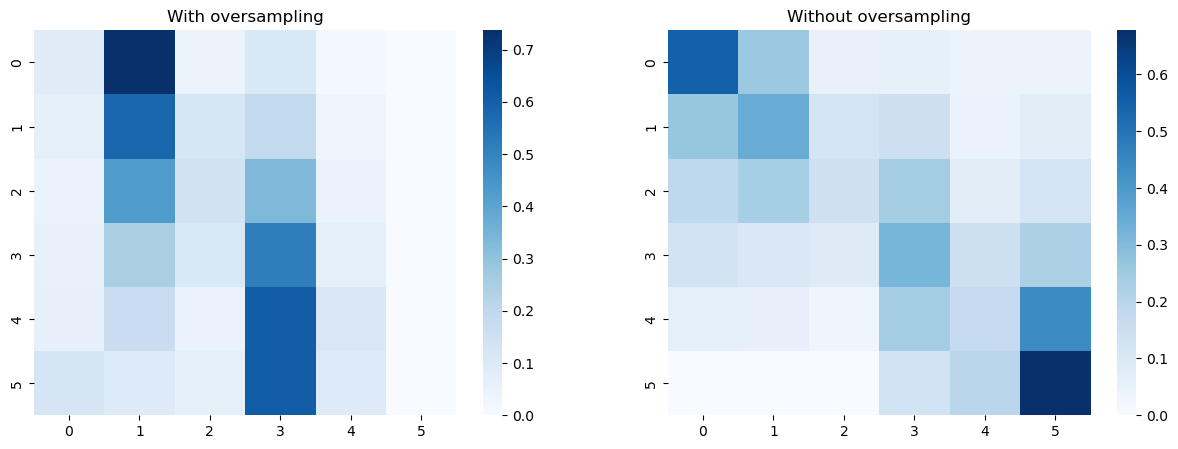

In [115]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

conf_matrix = confusion_matrix(df_test['labels'], gaussian_nb.predict(np.stack(df_test['word2vec'])))
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=False, ax=ax[0], fmt=".2f", cmap="Blues")
ax[0].set_title("With oversampling")

conf_matrix = confusion_matrix(df_test['labels'], gnb_unbalanced.predict(np.stack(df_test['word2vec'])))
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=False, ax=ax[1], fmt=".2f", cmap="Blues")
ax[1].set_title("Without oversampling")

plt.show()

In [116]:
gnb_unbalanced_ratio_err = GaussianNB()

train_ratio_err2 = np.stack(df_train_non_generated['word2vec'])
test_ratio_err2 = np.stack(df_test['word2vec'])

train_ratio_err2 = np.concatenate((train_ratio_err2, np.array(df_train_non_generated['ratio_err']).reshape(-1, 1)), axis=1)
test_ratio_err2 = np.concatenate((test_ratio_err2, np.array(df_test['ratio_err']).reshape(-1, 1)), axis=1)

gnb_unbalanced_ratio_err.fit(train_ratio_err2, df_train_non_generated['labels'])

GaussianNB()

In [117]:
print(classification_report(df_train_non_generated['labels'], gnb_unbalanced_ratio_err.predict(train_ratio_err2)))
print("-" * 55)
print(classification_report(df_test['labels'], gnb_unbalanced_ratio_err.predict(test_ratio_err2)))

              precision    recall  f1-score   support

           0       0.23      0.53      0.32      1001
           1       0.45      0.34      0.39      3084
           2       0.35      0.14      0.20      3084
           3       0.40      0.33      0.36      3084
           4       0.15      0.20      0.17       776
           5       0.06      0.82      0.12       125

    accuracy                           0.30     11154
   macro avg       0.27      0.40      0.26     11154
weighted avg       0.36      0.30      0.31     11154

-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.19      0.57      0.28       251
           1       0.43      0.35      0.39       945
           2       0.48      0.15      0.23      1256
           3       0.33      0.33      0.33       785
           4       0.12      0.18      0.14       194
           5       0.04      0.68      0.08        31

    accuracy         

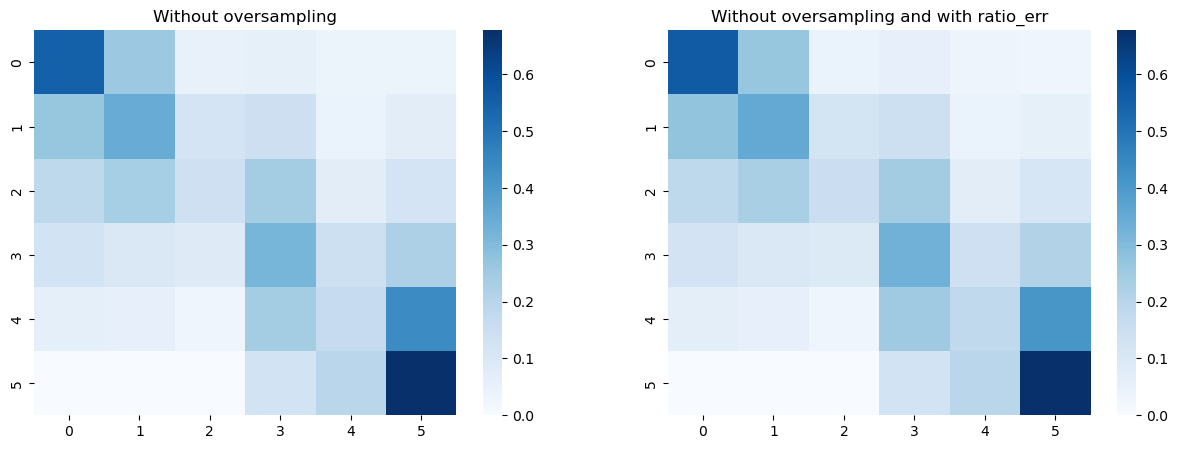

In [118]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

conf_matrix = confusion_matrix(df_test['labels'], gnb_unbalanced.predict(np.stack(df_test['word2vec'])))
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=False, ax=ax[0], fmt=".2f", cmap="Blues")
ax[0].set_title("Without oversampling")

conf_matrix = confusion_matrix(df_test['labels'], gnb_unbalanced_ratio_err.predict(test_ratio_err2))
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=False, ax=ax[1], fmt=".2f", cmap="Blues")
ax[1].set_title("Without oversampling and with ratio_err")

plt.show()